In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from calcwf import gen_wf, shifted_f, shifted_e, match_wfs, overlap_cplx_wfs, get_h

In [2]:
# Global settings
sample_rate = 4096

# Shifted frequency plots

In [3]:
# Calculates match over range of intial frequency values
def s_f_quad_match(fiducials, e_Ms, s_f_len, f_low, approximant, subsample_interpolation=True, match_fn='overlap_cplx'):

    # Generate fiducial waveform and data dictionary
    fid_wf = gen_wf(f_low, *fiducials, sample_rate, approximant)
    data = {}
    
    gridsize = len(e_Ms)*s_f_len
    progress = 0
    for i, e_M in enumerate(e_Ms):
        e, M = e_M
        
        # Creates grid dimension of shifted frequency
        max_s_f = shifted_f(f_low, e, M, fiducials[2])
        s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
        s_e_vals = shifted_e(s_f_vals, f_low, e)
        s_f_matches_1 = []
        s_f_matches_2 = []
        s_f_matches_ap = []
        s_f_matches_peri = []
    
        # Loops over each initial frequency
        for s_f, s_e in zip(s_f_vals, s_e_vals):
    
            # Create waveform to match
            h, h1, h2, h_ap, h_peri = get_h([1,1], s_f, s_e, M, fiducials[2], sample_rate, 
                                             approximant=approximant, subsample_interpolation=subsample_interpolation)

            # Choose which function to use to calculate matches
            if match_fn == 'match':
                # Matches against h1
                match = match_wfs(fid_wf, h1, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_1.append(match)
                # Matches against h2
                match = match_wfs(fid_wf, h2, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_2.append(match)
                # Matches against h_ap
                match = match_wfs(fid_wf, h_ap, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_ap.append(match)
                # Matches against h_peri
                match = match_wfs(fid_wf, h_peri, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_peri.append(match)
            elif match_fn == 'overlap_cplx':
                # Matches against h1
                match = overlap_cplx_wfs(fid_wf, h1, s_f)
                s_f_matches_1.append(abs(match))
                # Matches against h2
                match = overlap_cplx_wfs(fid_wf, h2, s_f)
                s_f_matches_2.append(abs(match))
                # Matches against h_ap
                match = overlap_cplx_wfs(fid_wf, h_ap, s_f)
                s_f_matches_ap.append(abs(match))
                # Matches against h_peri
                match = overlap_cplx_wfs(fid_wf, h_peri, s_f)
                s_f_matches_peri.append(abs(match))
            else:
                raise Exception('match_fn not recognised')

            # Progress bar
            progress += 1
            #if progress%10 == 0 or progress == gridsize:
            print('\r' + f'{progress} done out of {gridsize}', end='')
    

        # Calculate total quad match of h1 and h2
        s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)

        # Saves data
        data[e_M] = {}
        data[e_M]['h_ap'] = s_f_matches_ap
        data[e_M]['h_peri'] = s_f_matches_peri
        data[e_M]['h1'] = s_f_matches_1
        data[e_M]['h2'] = s_f_matches_2
        data[e_M]['h_quad'] = s_f_matches_quad
        data[e_M]['s_f_vals'] = s_f_vals
        data[e_M]['s_e_vals'] = s_e_vals

    return data

In [4]:
# Makes plot of quad match data
def plot_s_f_quad_match(fiducials, data, f_low, approximant, ylims=(0.9,1.01)):

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if len(data) == 1:
        ax2 = ax1.twiny()

    # Loops over each eccentricity/mass pair
    for i, e_M in enumerate(data.keys()):
        
        # Makes plot
        e, M = e_M
        ax1.plot(data[e_M]['s_f_vals'], data[e_M]['h1'], ls='dashed', c=f'C{i}', label=f'h1 $e={e}$, $M={M}~M_\odot$')
        ax1.plot(data[e_M]['s_f_vals'], data[e_M]['h2'], ls='dotted', c=f'C{i}', label=f'h2 $e={e}$, $M={M}~M_\odot$')
        ax1.plot(data[e_M]['s_f_vals'], data[e_M]['h_ap'], ls='dashdot', c=f'C{i}', label=f'h_ap $e={e}$, $M={M}~M_\odot$')
        ax1.plot(data[e_M]['s_f_vals'], data[e_M]['h_peri'], ls=(5, (10, 3)), c=f'C{i}', label=f'h_peri $e={e}$, $M={M}~M_\odot$')
        ax1.plot(data[e_M]['s_f_vals'], data[e_M]['h_quad'], ls='solid', c=f'C{i}', label=f'quad $e={e}$, $M={M}~M_\odot$')
        ax1.set_xlabel('Shifted frequency')
        if len(data) == 1:
            ax2.plot(data[e_M]['s_e_vals'], data[e_M]['h1'], alpha=0)
            ax2.invert_xaxis()
            ax2.set_xlabel('Shifted eccentricity')
        
    # Finish plot
    ax1.axhline(1, c='k', ls='dashed')
    ax1.legend(loc=(1,0))
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$, {approximant}')
    ax1.set_ylim(ylims)

In [5]:
start = time.time()
dataslot_1 = s_f_quad_match([0.1, 60, 2], [(0.1, 60), (0.2, 60)], 51, 10, 'TEOBResumS')
end = time.time()
print(f'\nTime taken: {start-end} seconds')

102 done out of 102
Time taken: -467.3745014667511 seconds


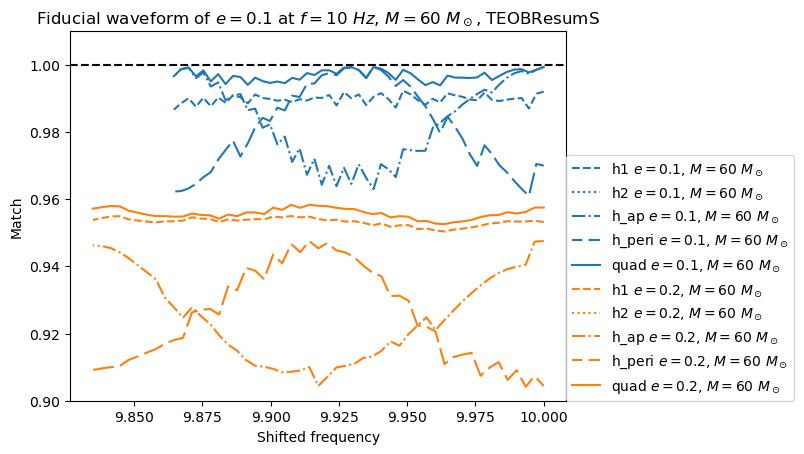

In [6]:
plot_s_f_quad_match([0.1, 60, 2], dataslot_1, 10, 'TEOBResumS')

In [7]:
dataslot_2 = s_f_quad_match([0.2, 60, 2], [(0.1, 60), (0.2, 60)], 51, 10, 'TEOBResumS')

102 done out of 102

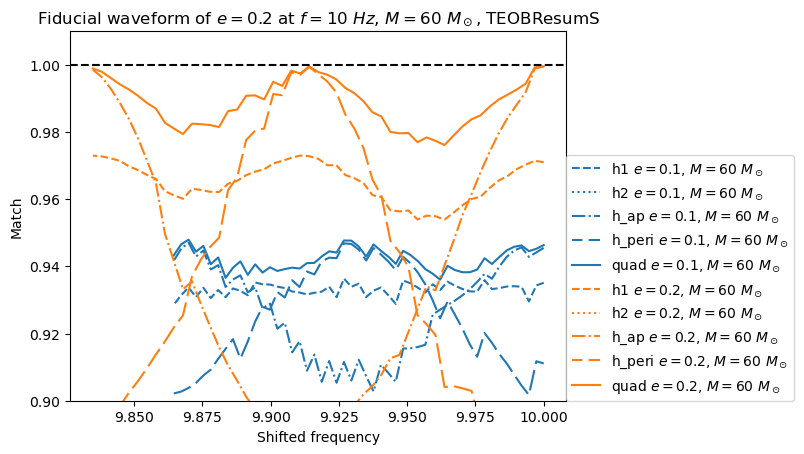

In [8]:
plot_s_f_quad_match([0.2, 60, 2], dataslot_2, 10, 'TEOBResumS')

In [9]:
dataslot_3 = s_f_quad_match([0.1, 60, 2], [(0.05, 60), (0.1, 60)], 21, 10, 'TEOBResumS')

42 done out of 42

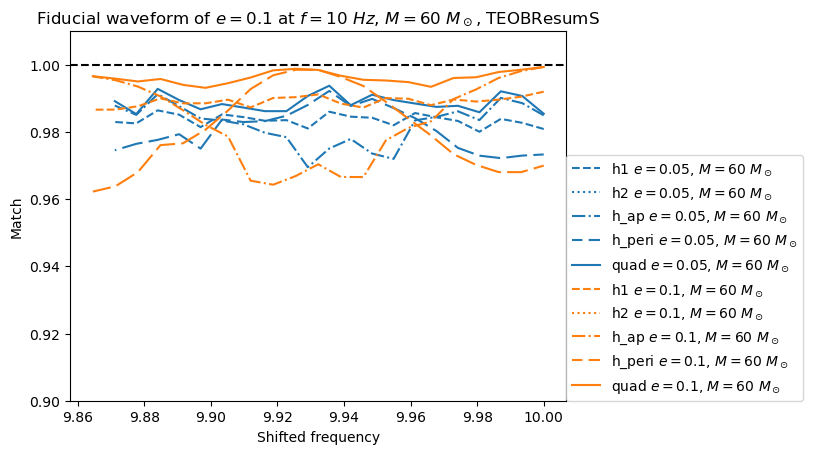

In [10]:
plot_s_f_quad_match([0.1, 60, 2], dataslot_3, 10, 'TEOBResumS')

# h_ap, h_peri normalisation

We model a total waveform $h$ in the following way:

$$
h = Ah_1+Bh_2
$$
$$
h_1 = \frac{1}{2}\left(h_{ap}+h_{peri}\right)
$$
$$
h_2 = \frac{1}{2}\left(h_{ap}-h_{peri}\right)
$$

When taking dot product (match) between total waveform and generated h1, we want to calculate the following:

$$
\frac{(h|h_1)}{(h_1|h_1)} = A\frac{(h_1|h_1)}{(h_1|h_1)} + B\frac{(h_2|h_1)}{(h_1|h_1)} = A
$$

This however assumes that $(h_1|h_2)$ is zero, which is of course not the case in practise. We therefore actually have an additional term proportional to:

$$
(h_1|h_2) = \frac{1}{4}\left[(h_{ap}|h_{ap})-(h_{peri}|h_{peri})\right]
$$

In order to make this unwanted term disappear we require $(h_{ap}|h_{ap})=(h_{peri}|h_{peri})$. (Note mismatch greater for higher masses due to effect of merger being stronger in either h_ap or h_peri). This can be achieved by defining normalised waveform components to use in our equations for $h$:

$$
\hat{h}_{ap} = \frac{h_{ap}}{\sqrt{(h_{ap}|h_{ap})}}
$$
$$
\hat{h}_{peri} = \frac{h_{peri}}{\sqrt{(h_{peri}|h_{peri})}}
$$

This will cause units of waveforms to change, however as we are simply matching them to each other rather than to data, this should be fine. If this does present a problem in the future, units can be (approximately) restored by multiplying both right hand sides by $\sqrt{(h_{ap}|h_{ap})}$ (note: have now done this).

We now have

$$
(\hat{h}_{ap}|\hat{h}_{ap}) = \frac{(h_{ap}|h_{ap})}{(h_{ap}|h_{ap})} = 1
$$

and similar for $\hat{h}_{peri}$. Therefore $(\hat{h}_1|\hat{h}_2) = 0$ as required.

We can check our implementation in calcwf.py by calculating $(h_1|h_2)$ and $(\hat{h}_1|\hat{h}_2)$.

In [3]:
# Calculates match without normalisation
_, unnorm_h1, unnorm_h2, unnorm_ap, unnorm_peri = get_h([1,1], 10, 0.2, 60, 2, sample_rate, approximant='TEOBResumS', normalisation=False)
unnorm_match = abs(overlap_cplx_wfs(unnorm_h1, unnorm_h2, 10))
print(f'Prior to normalisation, match of h1 and h2 is {unnorm_match}')

# Calculates match with normalisation
_, norm_h1, norm_h2, norm_ap, norm_peri = get_h([1,1], 10, 0.2, 60, 2, sample_rate, approximant='TEOBResumS')
norm_match = abs(overlap_cplx_wfs(norm_h1, norm_h2, 10))
print(f'After normalisation, match of h1 and h2 is {norm_match}')

Prior to normalisation, match of h1 and h2 is 0.007807869635770749
After normalisation, match of h1 and h2 is 0.00014267591321092882


Can also calculate $(h_{ap}|h_{ap})$ and $(h_{peri}|h_{peri})$.

In [4]:
# Calculates match without normalisation
unnorm_ap_match = abs(overlap_cplx_wfs(unnorm_ap, unnorm_ap, 10, normalized=False))
print(f'Prior to normalisation, (unnormalised) match of h_ap and h_ap is {unnorm_ap_match}')
unnorm_peri_match = abs(overlap_cplx_wfs(unnorm_peri, unnorm_peri, 10, normalized=False))
print(f'Prior to normalisation, (unnormalised) match of h_peri and h_peri is {unnorm_peri_match}')

# Calculates match with normalisation
norm_ap_match = abs(overlap_cplx_wfs(norm_ap, norm_ap, 10, normalized=False))
print(f'After normalisation, (unnormalised) match of h_ap and h_ap is {norm_ap_match}')
norm_peri_match = abs(overlap_cplx_wfs(norm_peri, norm_peri, 10, normalized=False))
print(f'After normalisation, (unnormalised) match of h_peri and h_peri is {norm_peri_match}')

Prior to normalisation, (unnormalised) match of h_ap and h_ap is 1193566149.137537
Prior to normalisation, (unnormalised) match of h_peri and h_peri is 1202186530.9956646
After normalisation, (unnormalised) match of h_ap and h_ap is 1193566149.137537
After normalisation, (unnormalised) match of h_peri and h_peri is 1193566149.1375368


# Generalisation to n waveform components

As before will start with:

$$
h = Ah_1+Bh_2+Ch_3
$$
$$
h_1 = \frac{1}{3}\left(s_0+s_1+s_2\right)
$$
$$
h_2 = \frac{1}{3}\left(s_0+z_1s_1+z_2s_2\right)
$$
$$
h_3 = \frac{1}{3}\left(s_0+z_2s_1+z_1s_2\right)
$$

where $z_1$, $z_2$ are the roots of unity $\omega$ and $\omega^2$.

We now want to enforce the condition

$$
\frac{(h|h_1)}{(h_1|h_1)} = A\frac{(h_1|h_1)}{(h_1|h_1)} + B\frac{(h_2|h_1)}{(h_1|h_1)} + C\frac{(h_3|h_1)}{(h_1|h_1)} = A
$$

which requires $(h_i|h_m) = 0$ for $i\neq m$.

For e.g. $(h_2|h_3)$, this comes down to enforcing

$$
(h_2|h_3) \propto (s_0|s_0) + z_2(s_0|s_1) + z_1(s_0|s_2) + z_1(s_1|s_0) + z_1z_2(s_1|s_1) + z_1^2(s_1|s_2) + z_2(s_2|s_0) + z_2^2(s_2|s_1) + z_2z_1(s_2|s_2) = 0
$$

$$
(s_0|s_0) + \omega^2(s_0|s_1) + \omega(s_0|s_2) + \omega(s_1|s_0) + (s_1|s_1) + \omega^2(s_1|s_2) + \omega^2(s_2|s_0) + \omega(s_2|s_1) + (s_2|s_2) = 0
$$

$$
(s_0|s_0) + (s_1|s_1) + (s_2|s_2) - (s_1|s_2) - (s_0|s_2) - (s_0|s_1) = 0
$$

Before we saw that the off-diagonal terms simply cancelled out, however this is not the case for a general number of waveform components. Repeat for $(h_1|h_2)$ and $(h_1|h_3)$ to get the full system of equations:

$$
(h_1|h_2) \propto (s_0|s_0) + z_1(s_0|s_1) + z_2(s_0|s_2) + (s_1|s_0) + z_1(s_1|s_1) + z_2(s_1|s_2) + (s_2|s_0) + z_1(s_2|s_1) + z_2(s_2|s_2) = 0
$$

$$
(s_0|s_0) + \omega(s_0|s_1) + \omega^2(s_0|s_2) + (s_1|s_0) + \omega(s_1|s_1) + \omega^2(s_1|s_2) + (s_2|s_0) + \omega(s_2|s_1) + \omega^2(s_2|s_2) = 0
$$

$$
(s_0|s_0) + \omega(s_1|s_1) + \omega^2(s_2|s_2) - (s_1|s_2) - \omega(s_0|s_2) - \omega^2(s_0|s_1) = 0
$$

and

$$
(h_1|h_3) \propto (s_0|s_0) + z_2(s_0|s_1) + z_1(s_0|s_2) + (s_1|s_0) + z_2(s_1|s_1) + z_1(s_1|s_2) + (s_2|s_0) + z_2(s_2|s_1) + z_1(s_2|s_2) = 0
$$

$$
(s_0|s_0) + \omega^2(s_0|s_1) + \omega(s_0|s_2) + (s_1|s_0) + \omega^2(s_1|s_1) + \omega(s_1|s_2) + (s_2|s_0) + \omega^2(s_2|s_1) + \omega(s_2|s_2) = 0
$$

$$
(s_0|s_0) + \omega^2(s_1|s_1) + \omega(s_2|s_2) - (s_1|s_2) - \omega^2(s_0|s_2) - \omega(s_0|s_1) = 0
$$

If $(s_0|s_0)$, $(s_1|s_1)$, and $(s_2|s_2)$ are all normalised to equal 1, like in the $n=2$ case, the first three terms in the last two equations will disappear as $1+\omega+\omega^2=0$. The last three terms would similarly also disappear as by symmetry we should expect $(s_1|s_2)=(s_0|s_2)=(s_0|s_1)$. The first equation however will stubbornly remain unsatisfied, as $(s_0|s_0) > (s_0|s_1)$ and so on by definition.

After performing this normalisation (and dropping hats for convenience of notation), we would get:

$$
\frac{(h|h_1)}{(h_1|h_1)} = A\frac{(h_1|h_1)}{(h_1|h_1)} + B\frac{(h_2|h_1)}{(h_1|h_1)} + C\frac{(h_3|h_1)}{(h_1|h_1)} = A
$$
$$
\frac{(h|h_2)}{(h_2|h_2)} = A\frac{(h_1|h_2)}{(h_2|h_2)} + B\frac{(h_2|h_2)}{(h_2|h_2)} + C\frac{(h_3|h_2)}{(h_2|h_2)} = B + C\frac{(h_3|h_2)}{(h_2|h_2)}
$$
$$
\frac{(h|h_3)}{(h_3|h_3)} = A\frac{(h_1|h_3)}{(h_3|h_3)} + B\frac{(h_2|h_3)}{(h_3|h_3)} + C\frac{(h_3|h_3)}{(h_3|h_3)} = B\frac{(h_2|h_3)}{(h_3|h_3)} + C
$$

We can explicitly calculate $(h_2|h_3)/(h_2|h_2)$ and $(h_2|h_3)/(h_3|h_3)$, so we just need to solve for $B$ and $C$:

$$
B = \frac{(h|h_2)}{(h_2|h_2)} - C\frac{(h_2|h_3)}{(h_2|h_2)}
$$
$$
C = \frac{(h|h_3)}{(h_3|h_3)} - B\frac{(h_2|h_3)}{(h_3|h_3)}
$$
$$
B = \frac{(h|h_2)}{(h_2|h_2)} - \frac{(h_2|h_3)}{(h_2|h_2)}\left(\frac{(h|h_3)}{(h_3|h_3)} - B\frac{(h_2|h_3)}{(h_3|h_3)}\right)
$$
$$
B\left(1 - \frac{(h_2|h_3)}{(h_2|h_2)}\frac{(h_2|h_3)}{(h_3|h_3)}\right) = \frac{(h|h_2)}{(h_2|h_2)} - \frac{(h_2|h_3)}{(h_2|h_2)}\frac{(h|h_3)}{(h_3|h_3)}
$$
$$
B = \frac{\frac{(h|h_2)}{(h_2|h_2)} - \frac{(h_2|h_3)}{(h_2|h_2)}\frac{(h|h_3)}{(h_3|h_3)}}{1 - \left[\frac{(h_2|h_3)}{(h_2|h_2)}\right]^2}
$$
$$
C = \frac{\frac{(h|h_3)}{(h_3|h_3)} - \frac{(h_2|h_3)}{(h_3|h_3)}\frac{(h|h_2)}{(h_2|h_2)}}{1 - \left[\frac{(h_2|h_3)}{(h_3|h_3)}\right]^2}
$$

with the equation for C calculated by symmetry.

Now let's attempt to do this for $n$ waveform components. Note the convention here to label $h_0,\ldots,h_{n-1}$ for ease of notation.

$$
h = \sum_{j=0}^{n-1} A_j h_j
$$
$$
h_j = \frac{1}{n}\sum_{k=0}^{n-1} \omega_n^{jk} s_k
$$

where $\omega_n$ is the first primitive $n$th root of unity, defined as equal to $e^{(2 \pi i/n)}$.

Now calculate $(h_j|h_m)$ for $j \neq m$ and try and force it to zero.

$$
(h_j|h_m) \propto \sum_{k=0}^{n-1} \sum_{l=0}^{n-1} \omega_n^{(jk+ml)} (s_k|s_l) = 0
$$

Separate out diagonal terms:

$$
\sum_{k=0}^{n-1} \omega_n^{k(j+m)} (s_k|s_k) + \sum_{k,l=0 \atop k\neq l}^{n-1} \omega_n^{(jk+ml)} (s_k|s_l) = 0
$$

And only sum over unique pairs:

$$
\sum_{k=0}^{n-1} \omega_n^{k(j+m)} (s_k|s_k) + \sum_{k=0}^{n-1}\sum_{l=k+1}^{n-1} \left(\omega_n^{(jk+ml)}+\omega_n^{(jl+mk)}\right) (s_k|s_l) = 0
$$

The roots of unity coefficients in the first term are all 1 if $j+m=n$, or sum to 0 otherwise. We can always normalise the diagonal terms to 1, so this first term is therefore analagous to the first three terms in each simultaneous equation for the $n=3$ case derived above.

The off-diagonal terms $(s_k|s_l)$ are also all equivalent for identical differences in true anomaly. For the $n=4$ case for example, this means we expect $(s_0|s_1) = (s_1|s_2) = (s_2|s_3) = (s_0|s_3)$, and $(s_0|s_2) = (s_1|s_3)$. We can therefore collect these 'like' terms in the second summation above.

$$
\sum_{k=0}^{n-1} \omega_n^{k(j+m)} (s_k|s_k) + \sum_{r=1}^{\lfloor n/2\rfloor} \sum_{t=0}^p \left(\omega_n^{(jt+m(t+r))}+\omega_n^{(j(t+r)+mt)}\right) (s_0|s_r) = 0
$$

where $\lfloor x \rfloor$ denotes the floor of $x$, and p is the number of pairs that can be made from the index difference $r$, equal to:

$$ p=   \left\{
\begin{array}{ll}
      0 & r>n/2 \\
      n/2 & r=n/2 \\
      n & r<n/2 \\
\end{array} 
\right.  $$

# Fiducial h1 and h2

Above we have generated a fiducial TEOB waveform and generated a new h1 and h2 waveform for each shifted frequency. If instead the opposite were to be done, with a fiducial h1 and h2 waveform to be matched against a generated TEOB waveform for each shifted frequency, the runtime would be greatly reduced as the TEOB waveform must only be called once for each shifted frequency instead of three times. To test whether this works, will create shifted frequency plots as above using this method and compare.

In [20]:
# Calculates match over range of intial frequency values
def s_f_quad_match_inv(fiducials, e_Ms, s_f_len, f_low, approximant, subsample_interpolation=True, match_fn='overlap_cplx'):

    # Generate fiducial waveform and data dictionary
    _, h1, h2, h_ap, h_peri = get_h([1,1], f_low, *fiducials, sample_rate,
                                    approximant=approximant, subsample_interpolation=subsample_interpolation)
    data = {}
    
    gridsize = len(e_Ms)*s_f_len
    progress = 0
    for i, e_M in enumerate(e_Ms):
        e, M = e_M
        
        # Creates grid dimension of shifted frequency
        max_s_f = shifted_f(f_low, e, M, fiducials[2])
        s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
        s_e_vals = shifted_e(s_f_vals, f_low, e)
        s_f_matches_1 = []
        s_f_matches_2 = []
        s_f_matches_ap = []
        s_f_matches_peri = []
    
        # Loops over each initial frequency
        for s_f, s_e in zip(s_f_vals, s_e_vals):
    
            # Create waveform to match
            s = gen_wf(s_f, s_e, M, fiducials[2], sample_rate, approximant)

            # Choose which function to use to calculate matches
            if match_fn == 'match':
                # Matches against h1
                match = match_wfs(s, h1, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_1.append(match)
                # Matches against h2
                match = match_wfs(s, h2, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_2.append(match)
                # Matches against h_ap
                match = match_wfs(s, h_ap, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_ap.append(match)
                # Matches against h_peri
                match = match_wfs(s, h_peri, s_f, subsample_interpolation=subsample_interpolation)
                s_f_matches_peri.append(match)
            elif match_fn == 'overlap_cplx':
                # Matches against h1
                match = overlap_cplx_wfs(h1, s, f_low)
                s_f_matches_1.append(abs(match))
                # Matches against h2
                match = overlap_cplx_wfs(h2, s, f_low)
                s_f_matches_2.append(abs(match))
                # Matches against h_ap
                match = overlap_cplx_wfs(h_ap, s, f_low)
                s_f_matches_ap.append(abs(match))
                # Matches against h_peri
                match = overlap_cplx_wfs(h_peri, s, f_low)
                s_f_matches_peri.append(abs(match))
            else:
                raise Exception('match_fn not recognised')

            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print('\r' + f'{progress} done out of {gridsize}', end='')
    

        # Calculate total quad match of h1 and h2
        s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)

        # Saves data
        data[e_M] = {}
        data[e_M]['h_ap'] = s_f_matches_ap
        data[e_M]['h_peri'] = s_f_matches_peri
        data[e_M]['h1'] = s_f_matches_1
        data[e_M]['h2'] = s_f_matches_2
        data[e_M]['h_quad'] = s_f_matches_quad
        data[e_M]['s_f_vals'] = s_f_vals
        data[e_M]['s_e_vals'] = s_e_vals

    return data

In [21]:
start = time.time()
dataslot_4 = s_f_quad_match_inv([0.1, 60, 2], [(0.1, 60), (0.2, 60)], 51, 10, 'TEOBResumS')
end = time.time()
print(f'\nTime taken: {start-end} seconds')

102 done out of 102
Time taken: -192.93523263931274 seconds


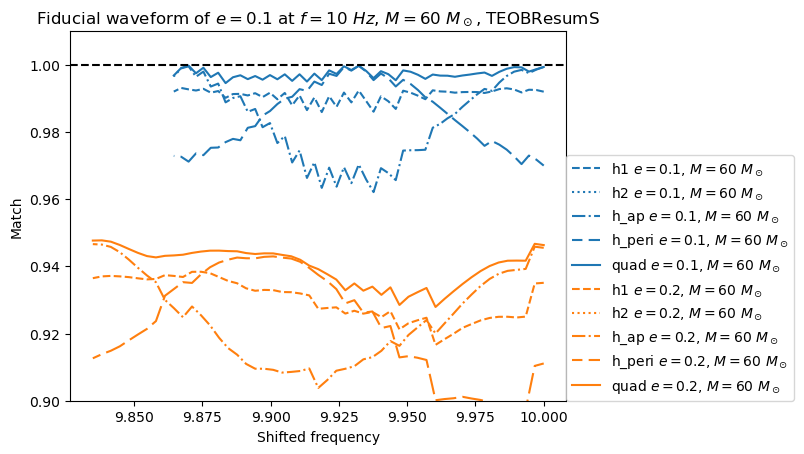

In [22]:
plot_s_f_quad_match([0.1, 60, 2], dataslot_4, 10, 'TEOBResumS')

This is a great reduction in time, and the blue e_10=0.1 lines look visually very similar. The orange e_10=0.2 lines do however look worse, with the patterns/trends less clear and an obvious dip in the (otherwise flat) quad match curve when shifting pi/2 backwards.